In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import xgboost as xgb
plt.style.use('fivethirtyeight')



In [141]:
# https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook
# https://www.youtube.com/watch?v=t6WSY9D_ORQ

sheet_id ='11Saxa9VOdM3uWCT9zNj2YPN-Pl1ukJLukkecNAE8USk'
df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")
df.set_index('Datetime', inplace=True)

In [142]:
df.head()

,PJME_MW
Datetime,
2002-12-31 1:00:00,26498
2002-12-31 2:00:00,25147
2002-12-31 3:00:00,24574
2002-12-31 4:00:00,24393
2002-12-31 5:00:00,24860


In [143]:
color_pal = sns.color_palette()

<Axes: title={'center': 'PJME Energy use in MW (Megawhats)'}, xlabel='Datetime'>

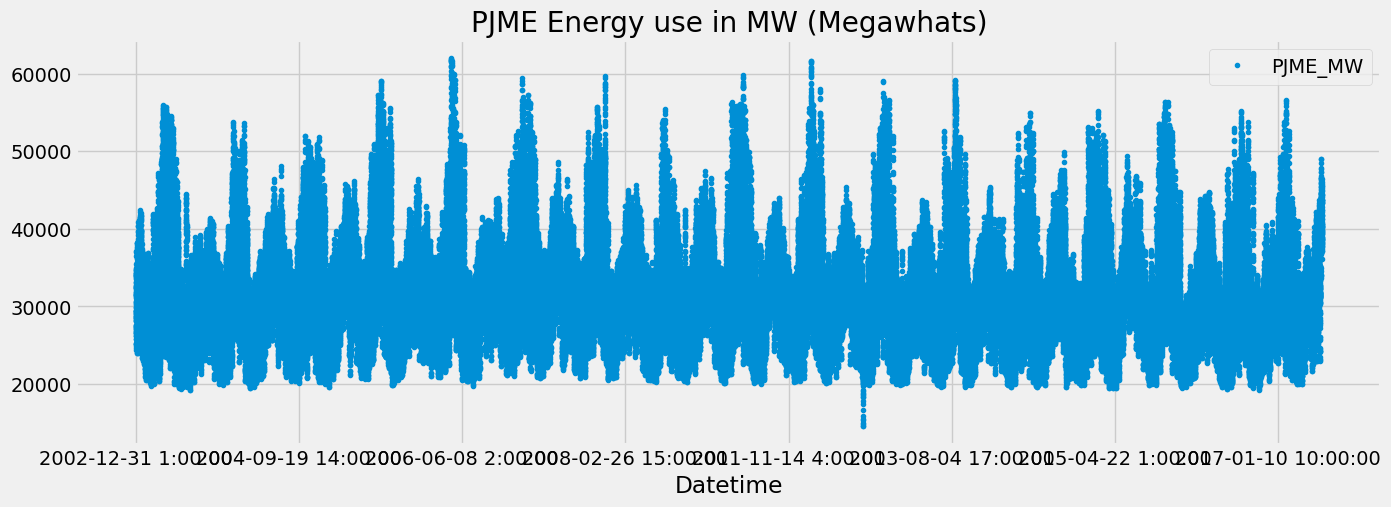

In [144]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title = 'PJME Energy use in MW (Megawhats)')

In [23]:
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy use in MW (Megawhats)'}, xlabel='Datetime'>

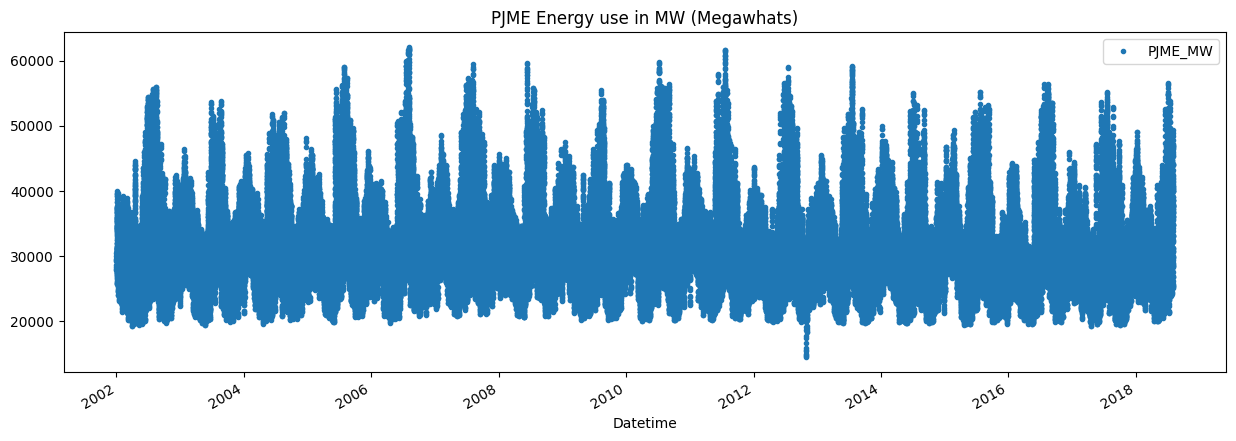

In [24]:
df.plot(style='.', 
figsize=(15,5), 
color=color_pal[0], 
title = 'PJME Energy use in MW (Megawhats)')

## Train / Test Split

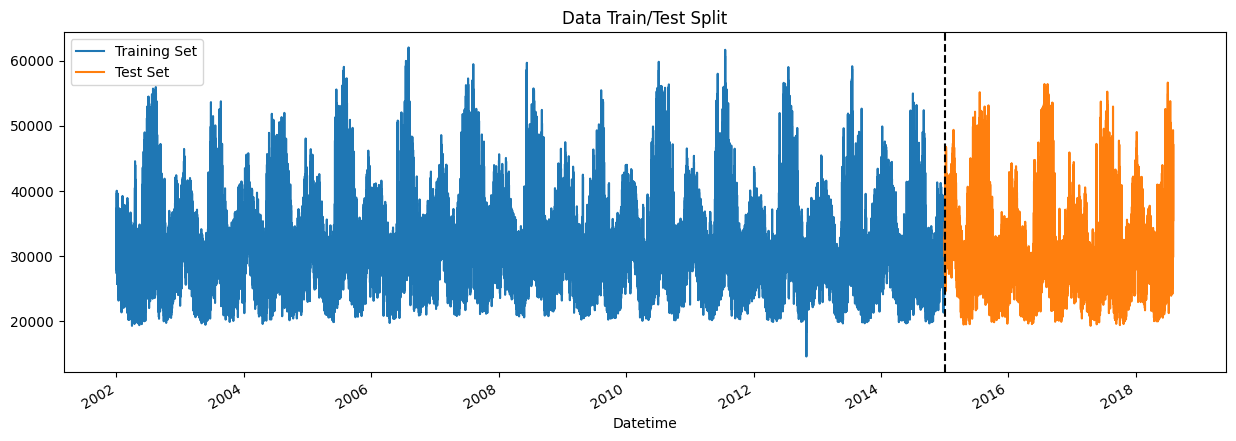

In [29]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

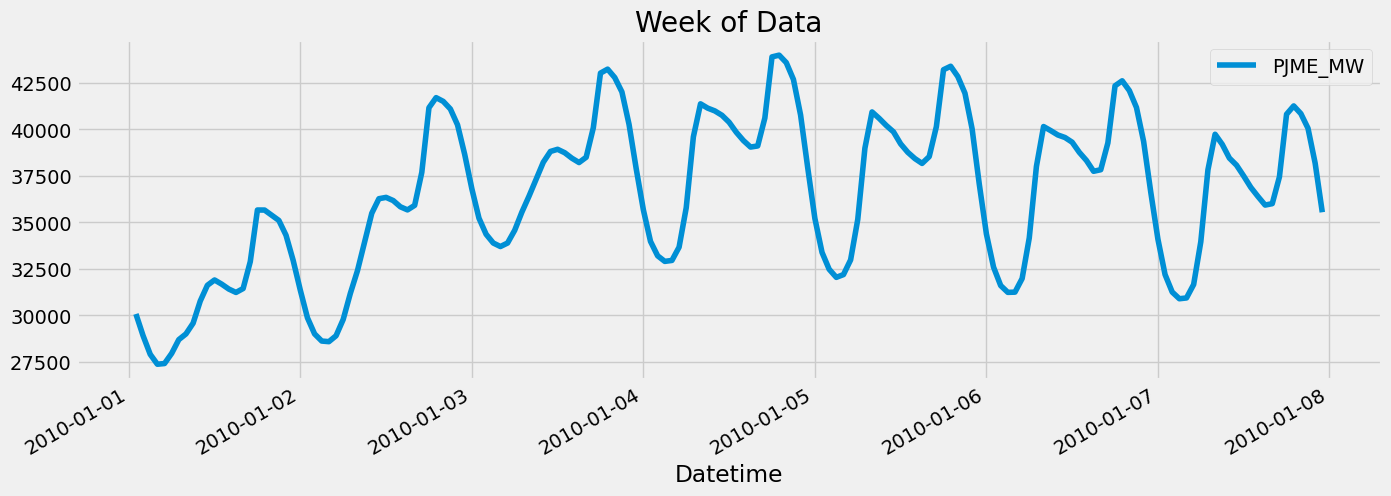

In [36]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')

## Feature Creation

In [51]:
def create_features(df):
    """
    Create time sereis feawtures based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [52]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize our Feature / Target Relationship

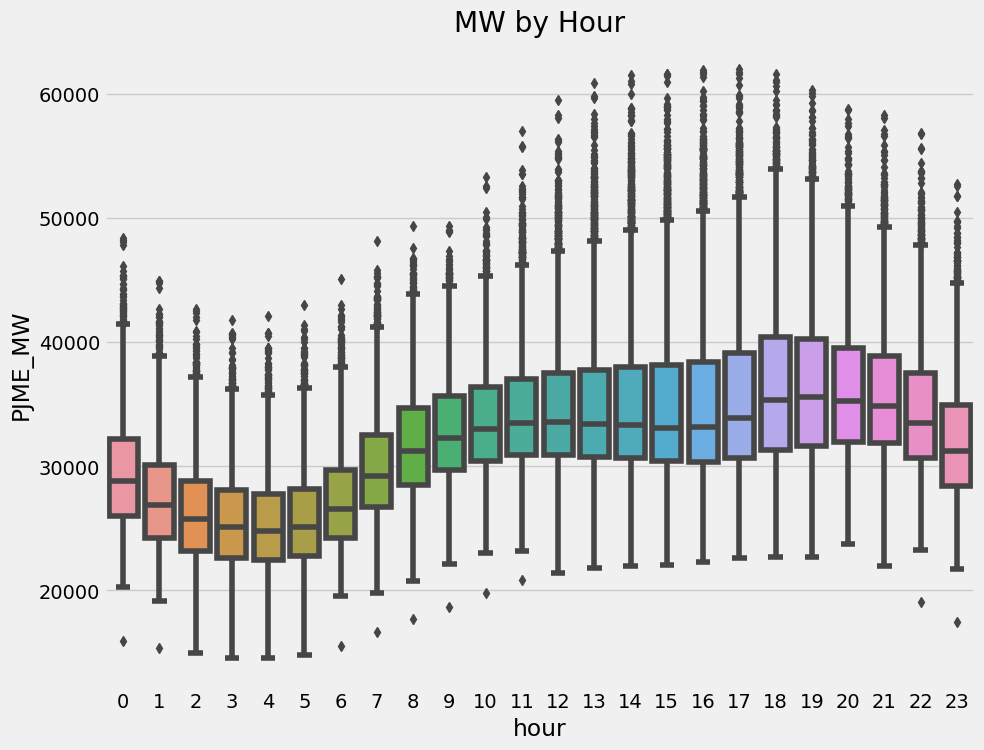

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

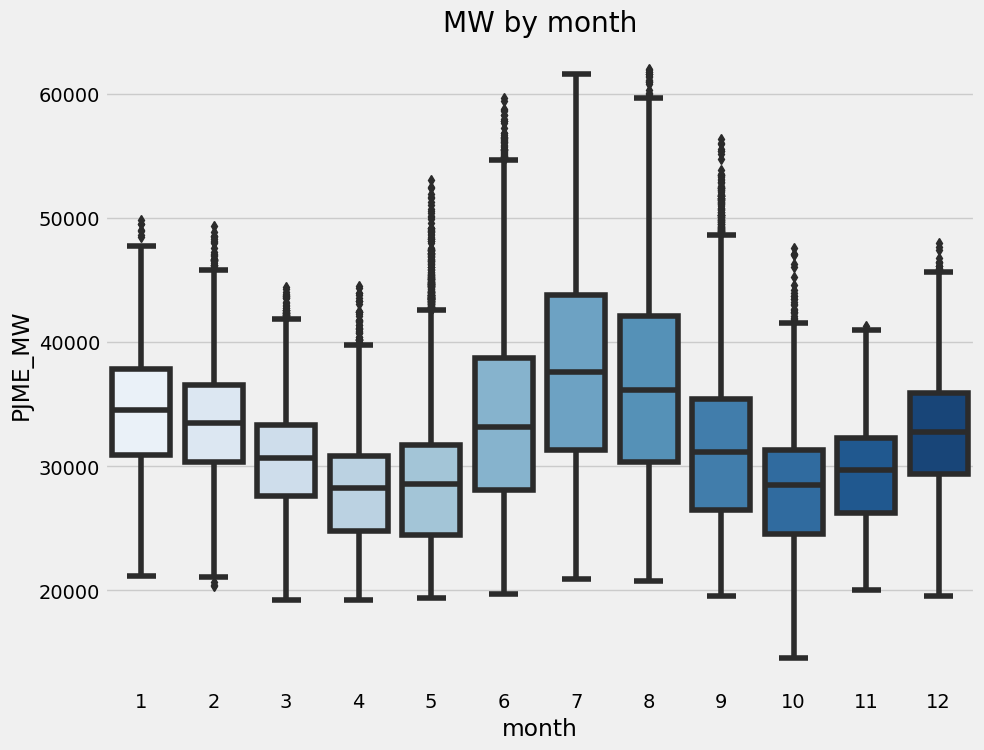

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW',  palette='Blues')
ax.set_title('MW by month')
plt.show()

## Create our Model

In [54]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'


In [55]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [62]:
pd.set_option('display.max_rows', 500)


In [64]:
# reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                        n_estimators=1000,
#                        early_stopping_rounds=50,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01)
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,learning_rate=.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84627	validation_1-rmse:27991.30072
[13]	validation_0-rmse:28660.79476	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63481	validation_1-rmse:27422.93836
[15]	validation_0-rmse:28099.33234	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importance

In [72]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

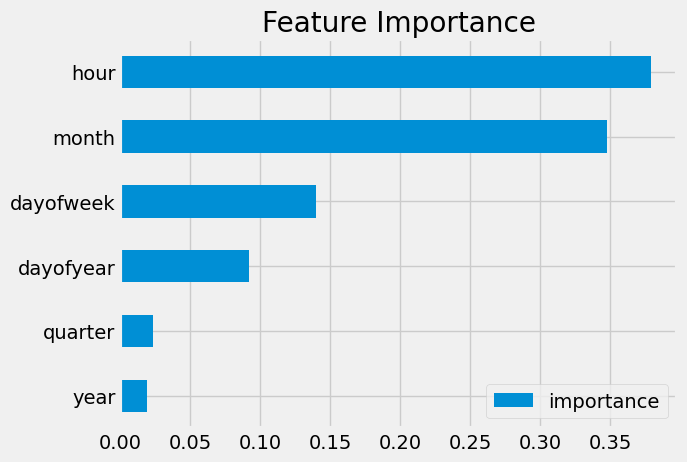

In [74]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

## Forecast on Test

In [76]:
test['prediction'] = reg.predict(X_test)

In [79]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

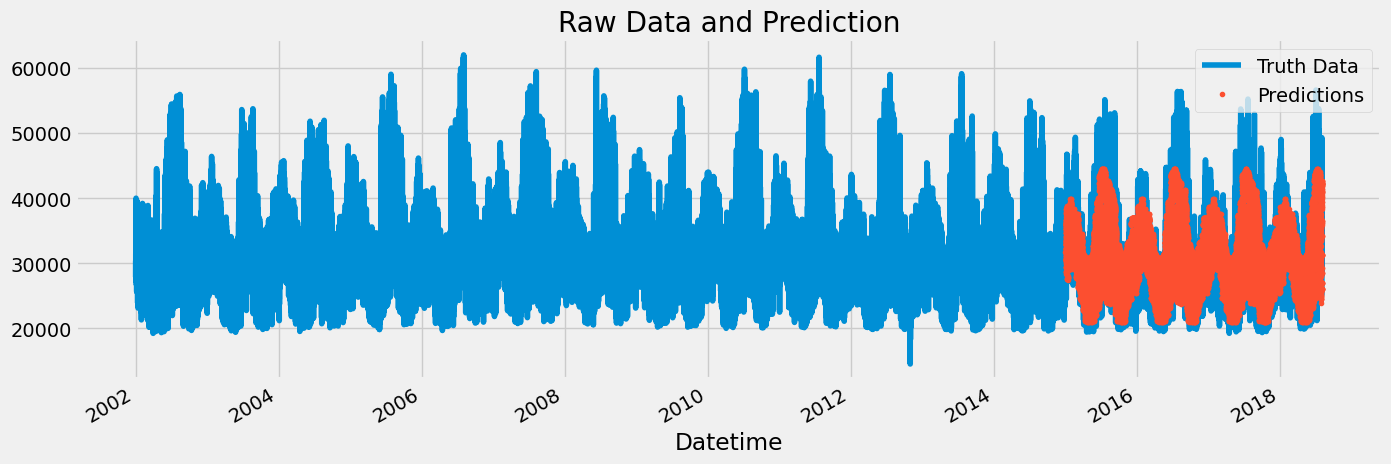

In [80]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
plt.legend()
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

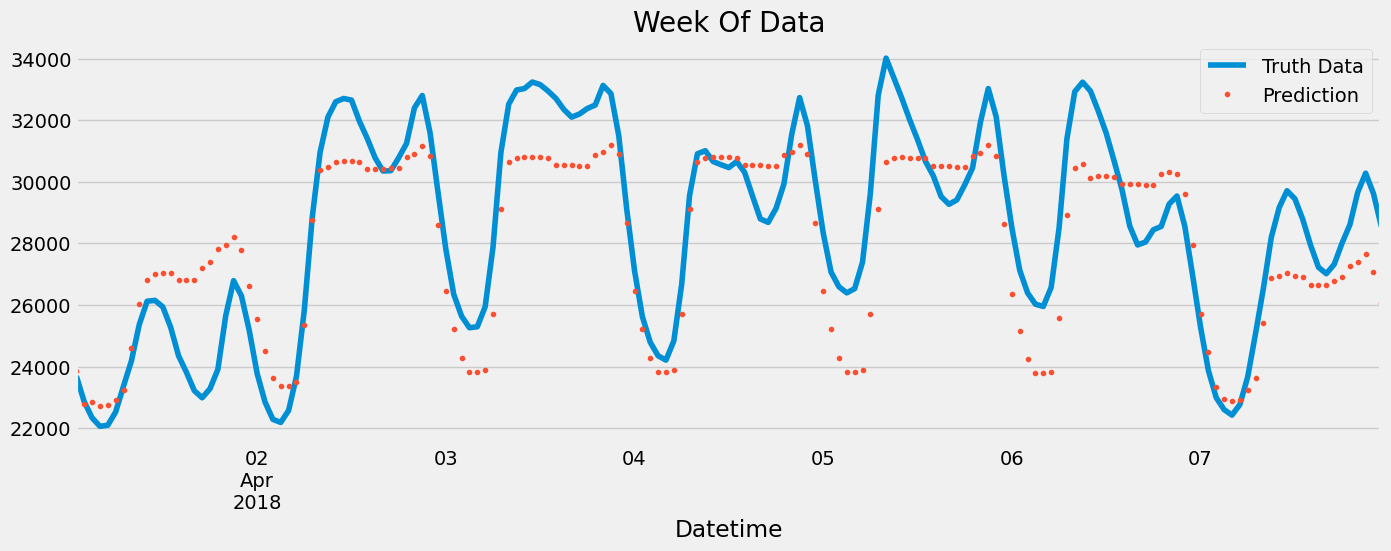

In [81]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [85]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE is {score}')

RMSE is 3714.697514518994


## Calculate Error

In [86]:
np.abs(test[TARGET] - test['prediction'])

Datetime
2015-01-01 00:00:00     986.486328
2015-12-31 01:00:00    4048.748047
2015-12-31 02:00:00    4047.925781
2015-12-31 03:00:00    4373.605469
2015-12-31 04:00:00    4557.605469
                          ...     
2018-01-01 20:00:00    7748.773438
2018-01-01 21:00:00    7317.398438
2018-01-01 22:00:00    7527.609375
2018-01-01 23:00:00    7037.777344
2018-01-02 00:00:00    6792.486328
Length: 31440, dtype: float64

In [90]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

In [91]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14559.813965
2016-08-14    14393.350830
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [92]:
test.groupby([`'date'])['error'].mean().sort_values(ascending=True).head(5)

date
2016-09-27    376.074788
2016-05-01    420.460449
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121745
Name: error, dtype: float64

### Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

## Part 2

In [94]:
df = pd.read_csv('./PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [98]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


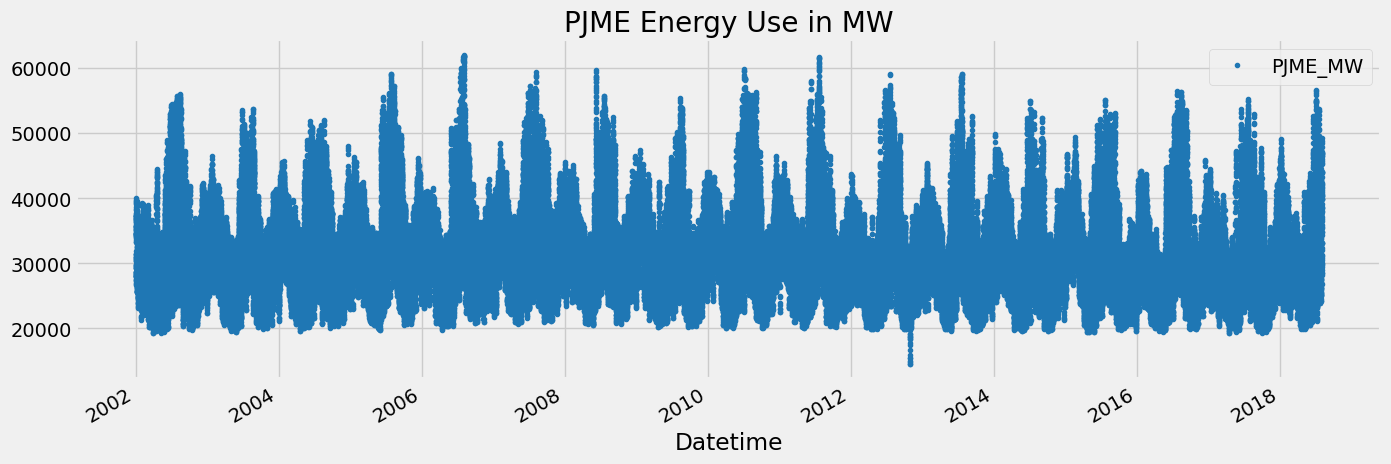

In [95]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

### Outlier Analysis and removal

<Axes: ylabel='Frequency'>

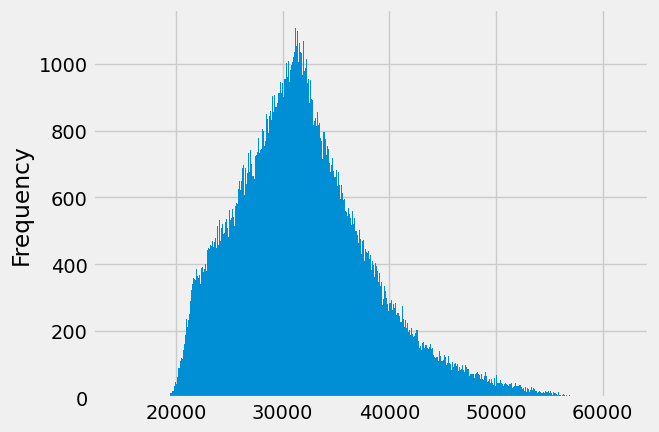

In [96]:
df['PJME_MW'].plot(kind='hist', bins=500)


<Axes: xlabel='Datetime'>

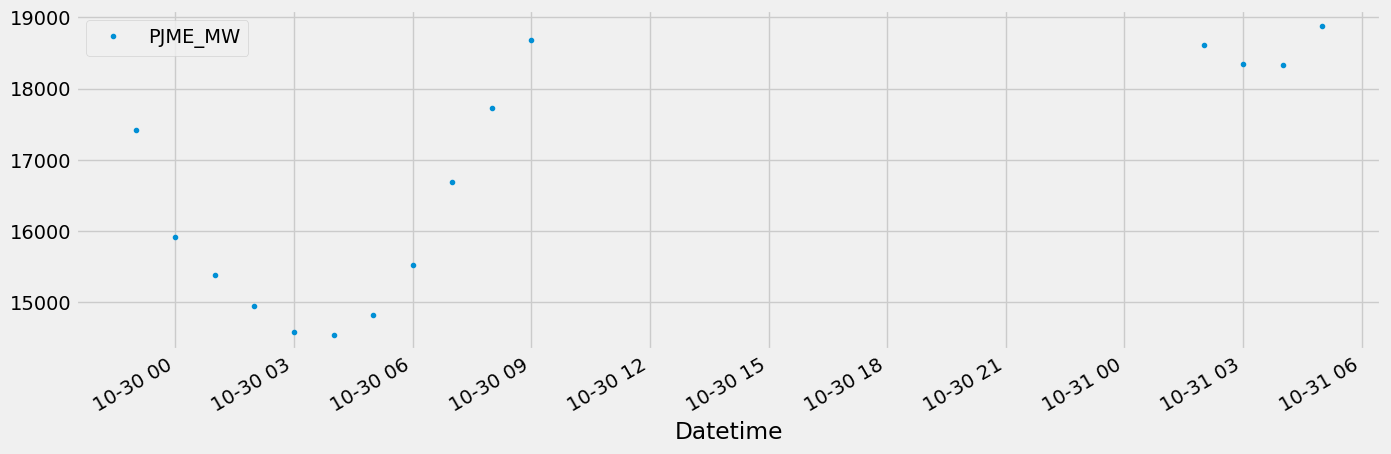

In [101]:
df.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.')

In [102]:
df = df.query('PJME_MW > 19_000').copy()

### Reviewing: Train / Test Split


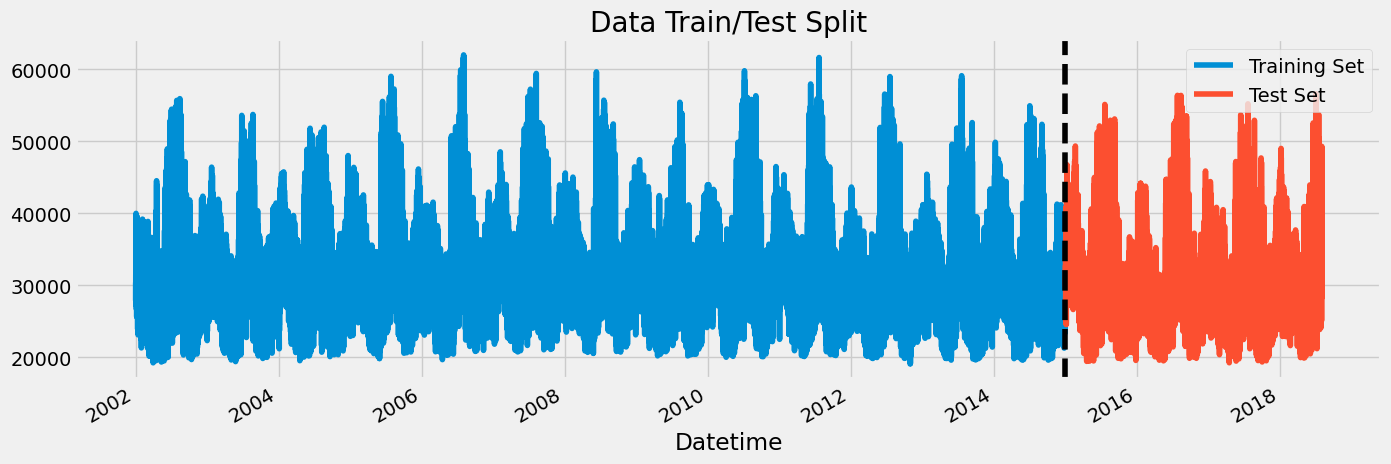

In [103]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

####  Time Series Cross Validation


In [105]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

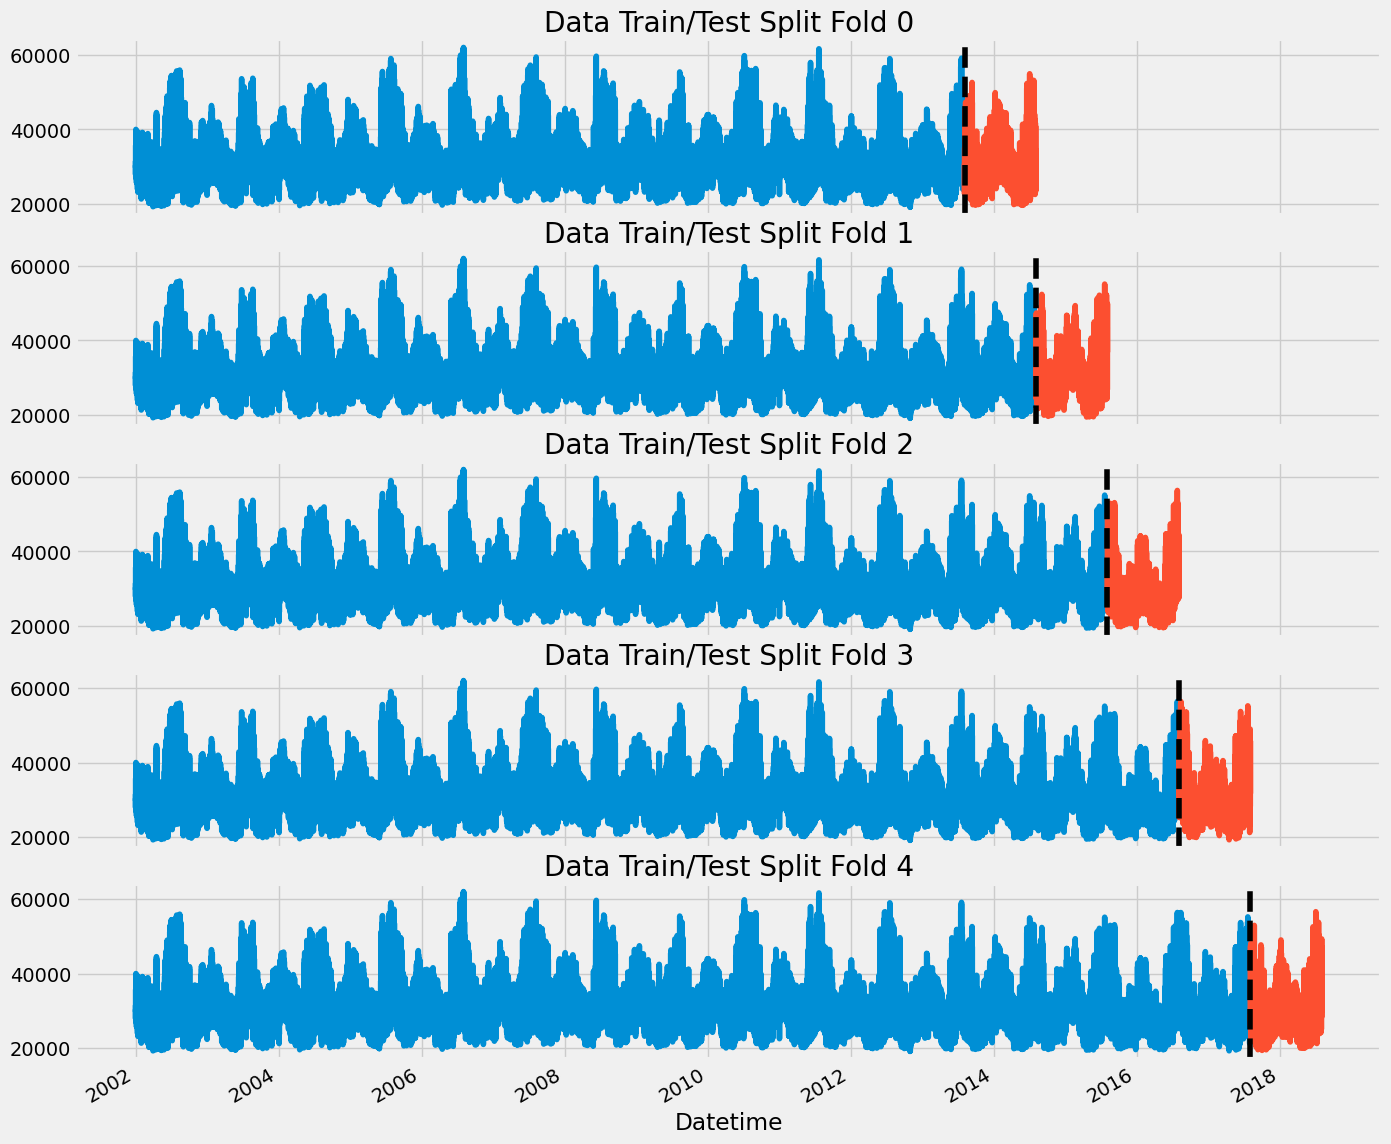

In [110]:
fig, axs = plt.subplots(5, 1, figsize=(15,15),sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

## 2. Forecast Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [111]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## 3. Lag Features

In [112]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [118]:
df = add_lags(df)

In [121]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,larg1,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN


## Train Using Cross Validation

In [122]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:53:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[450]	validation_0-rmse:3356.42691	validation_1-rmse:3762.64793
[16:54:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:565

In [123]:
scores

[3757.485267269142,
 3422.628654218696,
 3473.0621874794947,
 4115.966281700851,
 3998.8545666889618]

## 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation


In [124]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500, # Spot checking when it was overfitting
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:56:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [125]:
df.index.max()


Timestamp('2018-08-03 00:00:00')

In [133]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h') # 1st date is based on the previous row
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [134]:
future_w_features = df_and_future.query('isFuture').copy()


## Predict the future

In [135]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


<Axes: title={'center': 'Future Predictions'}>

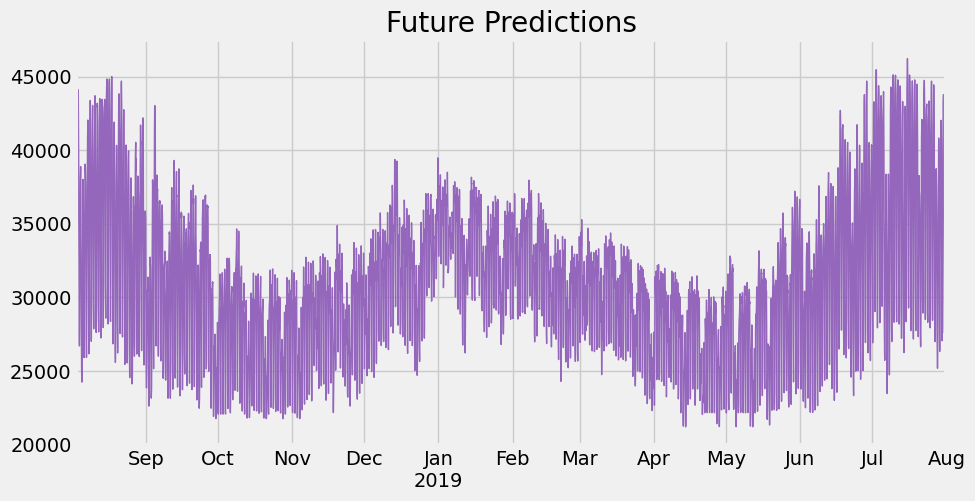

In [137]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                ``               ms=1,
                               lw=1,
                               title='Future Predictions')

## Bonus: Saving Model for later

In [138]:
reg.save_model('model.json')


In [139]:
!ls -lh


total 12344
-rw-rw-r--@ 1 iveksl2  staff   3.9M Oct  4  2019 PJME_hourly.csv
-rw-r--r--@ 1 iveksl2  staff   770K May  3 11:26 PJME_hourly.csv.zip
-rw-r--r--  1 iveksl2  staff   211B May  3 16:19 README.md
-rw-r--r--  1 iveksl2  staff   571K May  3 17:03 model.json
-rw-r--r--  1 iveksl2  staff   844K May  3 14:49 ts_video_rob_mulla.ipynb


<Axes: title={'center': 'Future Predictions'}>

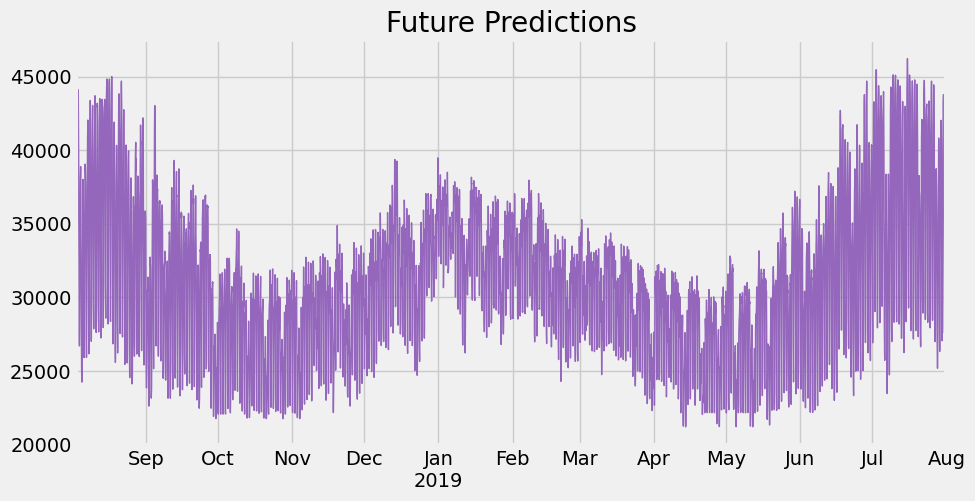

In [140]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')